# Análise Exploratória de Dados

## Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style='darkgrid')
palette = 'mako'
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

## Análise inicial

### Visão inicial dos dados

In [48]:
df = pd.read_pickle('../datasets/processed.pkl')
df.head()

data  consumo_energia  corrente_atrasada  corrente_principal   
0 2018-01-01 00:15:00             3.17               2.95                 0.0  \
1 2018-01-01 00:30:00             4.00               4.46                 0.0   
2 2018-01-01 00:45:00             3.24               3.28                 0.0   
3 2018-01-01 01:00:00             3.31               3.56                 0.0   
4 2018-01-01 01:15:00             3.82               4.50                 0.0   

   co2  potencia_atrasado  potencia_principal  segundos_depois_meia_noite   
0  0.0              73.21               100.0                         900  \
1  0.0              66.77               100.0                        1800   
2  0.0              70.28               100.0                        2700   
3  0.0              68.09               100.0                        3600   
4  0.0              64.72               100.0                        4500   

   estado_semana     dia_semana  tipo_carga  
0  Dia da Semana  Segunda-feira  Carga leve  
1  Dia da Semana  Segunda-feira  Carga leve  
2  Dia da Semana  Segunda-feira  Carga leve  
3  Dia da Semana  Segunda-feira  Carga leve  
4  Dia da Semana  Segunda-feira  Carga leve

Os dados já foram entregues tratados, sem valores null

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   data                        35040 non-null  datetime64[ns]
 1   consumo_energia             35040 non-null  float64       
 2   corrente_atrasada           35040 non-null  float64       
 3   corrente_principal          35040 non-null  float64       
 4   co2                         35040 non-null  float16       
 5   potencia_atrasado           35040 non-null  float64       
 6   potencia_principal          35040 non-null  float64       
 7   segundos_depois_meia_noite  35040 non-null  int32         
 8   estado_semana               35040 non-null  category      
 9   dia_semana                  35040 non-null  category      
 10  tipo_carga                  35040 non-null  category      
dtypes: category(3), datetime64[ns](1), float16(1), float64

Observação dos dados numéricos

Foram desconsideradas as variáveis referente a data e segundos depois da meia noite, por serem medidas de tempo

In [50]:
df.drop(columns=['data', 'segundos_depois_meia_noite']).describe().T.drop('count', axis=1)

mean        std  min    25%     50%         75%   
consumo_energia     27.386892  33.444380  0.0   3.20    4.57   51.237500  \
corrente_atrasada   13.035384  16.306000  0.0   2.30    5.00   22.640000   
corrente_principal   3.870949   7.424463  0.0   0.00    0.00    2.090000   
co2                  0.011520   0.016144  0.0   0.00    0.00    0.020004   
potencia_atrasado   80.578056  18.921322  0.0  63.32   87.96   99.022500   
potencia_principal  84.367870  30.456535  0.0  99.70  100.00  100.000000   

                           max  
consumo_energia     157.180000  
corrente_atrasada    96.910000  
corrente_principal   27.760000  
co2                   0.070007  
potencia_atrasado   100.000000  
potencia_principal  100.000000

Observação dos dados categóricos

In [51]:
df.describe(exclude=[np.number, np.datetime64]).T.drop('count', axis=1)

unique            top   freq
estado_semana      2  Dia da Semana  25056
dia_semana         7  Segunda-feira   5088
tipo_carga         3     Carga leve  18072

Analisando a quantidade de dados unicos

In [52]:
df.nunique()

data                          35040
consumo_energia                3343
corrente_atrasada              1954
corrente_principal              768
co2                               8
potencia_atrasado              5079
potencia_principal             3366
segundos_depois_meia_noite       96
estado_semana                     2
dia_semana                        7
tipo_carga                        3
dtype: int64

### A partir do site do governo foi adquirido as datas referentes as estações do ano

- [Verão: 21 dezembro, às (14h28) de 2017 a 20 de março de 2018 (13h14);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/verao-2017-comeca-no-dia-21-de-dezembro-as-14h28)
- [Verão: de 21 de dezembro (20h22) a 20 de março de 2019 (18h58);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/verao-2018)
- [Outono: de 20 de março (13h14) a 21 de junho de 2018 (7h07);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/outono-2018-comeca-no-proximo-dia-20)
- [Inverno: de 21 de junho (7h07) a 22 de setembro de 2018 (22h53);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/solsticio-inverno-2018)
- [Primavera: de 22 de setembro (22h53) a 21 de dezembro de 2018 (20h22).](https://www.gov.br/observatorio/pt-br/assuntos/noticias/primavera-2018)

In [53]:
def estacao_do_ano(data):
    verao_2018_inicio = pd.Timestamp('2017-12-21 14:28:00')
    verao_2018_fim = pd.Timestamp('2018-03-20 13:14:00')
    verao_2019_inicio = pd.Timestamp('2018-12-21 20:22:00')
    verao_2019_fim = pd.Timestamp('2019-03-20 18:58:00')
    outono_inicio = pd.Timestamp('2018-03-20 13:14:00')
    outono_fim = pd.Timestamp('2018-06-21 07:07:00')
    inverno_inicio = pd.Timestamp('2018-06-21 07:07:00')
    inverno_fim = pd.Timestamp('2018-09-22 22:53:00')
    primavera_inicio = pd.Timestamp('2018-09-22 22:53:00')
    primavera_fim = pd.Timestamp('2018-12-21 20:22:00')
    
    if verao_2018_inicio <= data < verao_2018_fim or verao_2019_inicio <= data < verao_2019_fim:
        return 'Verão'
    elif outono_inicio <= data < outono_fim:
        return 'Outono'
    elif inverno_inicio <= data < inverno_fim:
        return 'Inverno'
    elif primavera_inicio <= data < primavera_fim:
        return 'Primavera'
    else:
        return 'Fora do intervalo'

df['estacao'] = df['data'].apply(estacao_do_ano)
del estacao_do_ano

### Observação da variável target em ordem crescente e decrescente

Apesar dos dados não possuirem valores null, foi observado uma linha completamente nula, podendo ser considerado um outlier, ou um erro na medição

In [54]:
df.sort_values('consumo_energia', ascending=True).head(10)

data  consumo_energia  corrente_atrasada   
29855 2018-07-11 00:00:00             0.00               0.00  \
25848 2018-09-27 06:15:00             2.45               4.93   
25847 2018-09-27 06:00:00             2.45               4.97   
26234 2018-01-10 06:45:00             2.45               4.36   
25851 2018-09-27 07:00:00             2.45               5.08   
26018 2018-09-29 00:45:00             2.45               4.00   
25820 2018-09-26 23:15:00             2.45               4.64   
25822 2018-09-26 23:45:00             2.45               4.61   
25821 2018-09-26 23:30:00             2.45               4.61   
23733 2018-05-09 05:30:00             2.48               5.00   

       corrente_principal  co2  potencia_atrasado  potencia_principal   
29855                 0.0  0.0               0.00                 0.0  \
25848                 0.0  0.0              44.50               100.0   
25847                 0.0  0.0              44.22               100.0   
26234                 0.0  0.0              48.99               100.0   
25851                 0.0  0.0              43.44               100.0   
26018                 0.0  0.0              52.23               100.0   
25820                 0.0  0.0              46.69               100.0   
25822                 0.0  0.0              46.93               100.0   
25821                 0.0  0.0              46.93               100.0   
23733                 0.0  0.0              44.43               100.0   

       segundos_depois_meia_noite    estado_semana     dia_semana  tipo_carga   
29855                           0    Dia da Semana   Quarta-feira  Carga leve  \
25848                       22500    Dia da Semana   Quinta-feira  Carga leve   
25847                       21600    Dia da Semana   Quinta-feira  Carga leve   
26234                       24300    Dia da Semana  Segunda-feira  Carga leve   
25851                       25200    Dia da Semana   Quinta-feira  Carga leve   
26018                        2700  Final de Semana         Sabado  Carga leve   
25820                       83700    Dia da Semana   Quarta-feira  Carga leve   
25822                       85500    Dia da Semana   Quarta-feira  Carga leve   
25821                       84600    Dia da Semana   Quarta-feira  Carga leve   
23733                       19800    Dia da Semana   Quarta-feira  Carga leve   

         estacao  
29855    Inverno  
25848  Primavera  
25847  Primavera  
26234      Verão  
25851  Primavera  
26018  Primavera  
25820  Primavera  
25822  Primavera  
25821  Primavera  
23733     Outono

In [55]:
df.sort_values('consumo_energia', ascending=False).head(10)

data  consumo_energia  corrente_atrasada   
31238 2018-11-22 09:45:00           157.18              77.72  \
1398  2018-01-15 13:45:00           153.14              70.45   
31723 2018-11-27 11:00:00           151.67              69.73   
7812  2018-03-23 09:15:00           151.31              65.20   
1701  2018-01-18 17:30:00           149.65              64.87   
33848 2018-12-19 14:15:00           149.18              74.56   
162   2018-02-01 16:45:00           147.46              65.27   
6111  2018-05-03 16:00:00           146.88              70.49   
1679  2018-01-18 12:00:00           146.48              84.89   
447   2018-05-01 16:00:00           146.34              66.92   

       corrente_principal       co2  potencia_atrasado  potencia_principal   
31238                 0.0  0.070007              89.64               100.0  \
1398                  0.0  0.070007              90.85               100.0   
31723                 0.0  0.070007              90.86               100.0   
7812                  0.0  0.070007              91.84               100.0   
1701                  0.0  0.070007              91.75               100.0   
33848                 0.0  0.070007              89.45               100.0   
162                   0.0  0.000000              91.44               100.0   
6111                  0.0  0.070007              90.16               100.0   
1679                  0.0  0.070007              86.52               100.0   
447                   0.0  0.070007              90.94               100.0   

       segundos_depois_meia_noite  estado_semana     dia_semana    tipo_carga   
31238                       35100  Dia da Semana   Quinta-feira   Carga media  \
1398                        49500  Dia da Semana  Segunda-feira   Carga media   
31723                       39600  Dia da Semana    Terca-feira  Carga maxima   
7812                        33300  Dia da Semana    Sexta-feira   Carga media   
1701                        63000  Dia da Semana   Quinta-feira  Carga maxima   
33848                       51300  Dia da Semana   Quarta-feira   Carga media   
162                         60300  Dia da Semana    Terca-feira   Carga media   
6111                        57600  Dia da Semana  Segunda-feira  Carga maxima   
1679                        43200  Dia da Semana   Quinta-feira  Carga maxima   
447                         57600  Dia da Semana    Sexta-feira   Carga media   

         estacao  
31238  Primavera  
1398       Verão  
31723  Primavera  
7812      Outono  
1701       Verão  
33848  Primavera  
162        Verão  
6111      Outono  
1679       Verão  
447       Outono

### Análise referente aos meses

In [56]:
def get_mode(x: pd.Series) -> str:
    return x.mode()[0]

df_groupby_month = df.groupby(df.data.dt.month_name(), sort=False).agg(
    {
        'consumo_energia': ['mean', 'median'],
        'corrente_atrasada': ['mean', 'median'],
        'corrente_principal': ['mean', 'median'],
        'co2': ['mean', 'median'],
        'potencia_atrasado': ['mean', 'median'],
        'potencia_principal': ['mean', 'median'],
        'dia_semana': get_mode,
        'tipo_carga': get_mode,
    }
)

del get_mode

df_groupby_month

consumo_energia        corrente_atrasada        corrente_principal   
                     mean median              mean median               mean   
data                                                                           
January         33.876300  13.68         15.136035   5.18           4.520719  \
February        29.330588   5.15         12.377035   4.86           4.434911   
March           27.107282   4.46         11.852571   4.57           3.993380   
April           25.923153   4.12         12.074792   4.28           4.427858   
May             28.636166   4.21         13.803901   5.15           3.579778   
June            25.909760   4.21         12.484104   5.18           3.726187   
July            27.497762   4.05         12.963784   5.08           3.508673   
August          28.021788   4.43         14.766176   5.47           2.888901   
September       20.581271   3.42         11.048615   5.11           3.855295   
October         27.564022   4.46         14.895481   5.98           3.486727   
November        30.867705   5.11         14.681601   5.15           3.175757   
December        23.312893   4.25         10.217043   3.31           4.898138   

                       co2           potencia_atrasado           
          median      mean    median              mean  median   
data                                                             
January     0.00  0.014759  0.010002         85.030961  90.010  \
February    0.00  0.011741  0.000000         83.319107  89.740   
March       0.00  0.011476  0.000000         81.274617  88.640   
April       0.00  0.010879  0.000000         81.075212  87.690   
May         0.00  0.012218  0.000000         78.506962  86.950   
June        0.00  0.010903  0.000000         78.559090  87.365   
July        0.00  0.011698  0.000000         80.922403  90.175   
August      0.00  0.011912  0.000000         76.723044  86.025   
September   0.00  0.008431  0.000000         76.982681  86.400   
October     0.00  0.011573  0.000000         76.964345  85.605   
November    0.00  0.013087  0.000000         81.948656  87.965   
December    0.04  0.009550  0.000000         85.774002  89.655   

          potencia_principal            dia_semana  tipo_carga  
                        mean median       get_mode    get_mode  
data                                                            
January            84.085104  100.0        Domingo  Carga leve  
February           82.301150  100.0    Sexta-feira  Carga leve  
March              85.479073  100.0         Sabado  Carga leve  
April              83.314701  100.0        Domingo  Carga leve  
May                86.133770  100.0  Segunda-feira  Carga leve  
June               85.753622  100.0   Quinta-feira  Carga leve  
July               83.770171  100.0        Domingo  Carga leve  
August             87.687722  100.0   Quinta-feira  Carga leve  
September          80.129663  100.0    Sexta-feira  Carga leve  
October            85.193646  100.0         Sabado  Carga leve  
November           87.589590  100.0        Domingo  Carga leve  
December           80.754160  100.0  Segunda-feira  Carga leve

Apenas com esse agrupamento foi observada uma forte correlação referente ao consumo de energia e a corrente atrasada, então ordenamos os meses referentes as duas variaveis e comparamos

In [57]:
consumo_energia = df_groupby_month.consumo_energia.sort_values('mean', ascending=False).index, df_groupby_month.consumo_energia.sort_values('median', ascending=False).index
corrente_atrasada = df_groupby_month.corrente_atrasada.sort_values('mean', ascending=False).index, df_groupby_month.corrente_atrasada.sort_values('median', ascending=False).index

In [58]:
# Mean
pd.DataFrame(data=[consumo_energia[0], corrente_atrasada[0]], index=['consumo_energia', 'corrente_atrasada']).T

consumo_energia corrente_atrasada
0          January           January
1         November           October
2         February            August
3              May          November
4           August               May
5          October              July
6             July              June
7            March          February
8            April             April
9             June             March
10        December         September
11       September          December

In [59]:
# Median
pd.DataFrame(data=[consumo_energia[1], corrente_atrasada[1]], index=['consumo_energia', 'corrente_atrasada']).T

consumo_energia corrente_atrasada
0          January           October
1         February            August
2         November           January
3            March              June
4          October               May
5           August          November
6         December         September
7              May              July
8             June          February
9            April             March
10            July             April
11       September          December

## Análise gráfica

### Histograma

Inicialmente vamos observar o histograma desses dados, assim observando como sua distribuição se comporta.

Para tal foram desconsiderados elementos:

- categóricos 
    - Estado da semana
    - Dia da semana
    - Tipo de carga
- temporais
    - Data
    - Estação
    - Segundos após a meia noite

Foi observado que apesar do seu valor flutuante a variável co2 se comporta de maneira categórica, por possuir apenas 8 elementos únicos.

In [60]:
df.head(1)

data  consumo_energia  corrente_atrasada  corrente_principal   
0 2018-01-01 00:15:00             3.17               2.95                 0.0  \

   co2  potencia_atrasado  potencia_principal  segundos_depois_meia_noite   
0  0.0              73.21               100.0                         900  \

   estado_semana     dia_semana  tipo_carga estacao  
0  Dia da Semana  Segunda-feira  Carga leve   Verão

In [61]:
columns

Index(['consumo_energia', 'corrente_atrasada', 'corrente_principal', 'co2',
       'potencia_atrasado', 'potencia_principal'],
      dtype='object')

In [62]:
def plot_histograms(df: pd.DataFrame, columns: list, n_rows: int, n_cols: int, title: list):
    fig = plt.figure(figsize=(20, 16))
    for i, column in enumerate(columns):
        if column == 'co2':
            df.co2 = df.co2 * 100
            df.co2 = df.co2.astype(int)
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.histplot(data=df, x=column, ax=ax, bins=20, kde=True, color='#0f2d56', alpha=.75)
        for value in ax.containers:
            ax.bar_label(value, label_type='edge', fontsize=9, family='monospace')
        ax.set_xlabel(None)
        ax.set_ylabel('Contagem', fontsize='large', family='monospace')
        ax.set_title(title[i], fontsize='large', fontweight='bold', style='italic', family='monospace')
    fig.tight_layout()

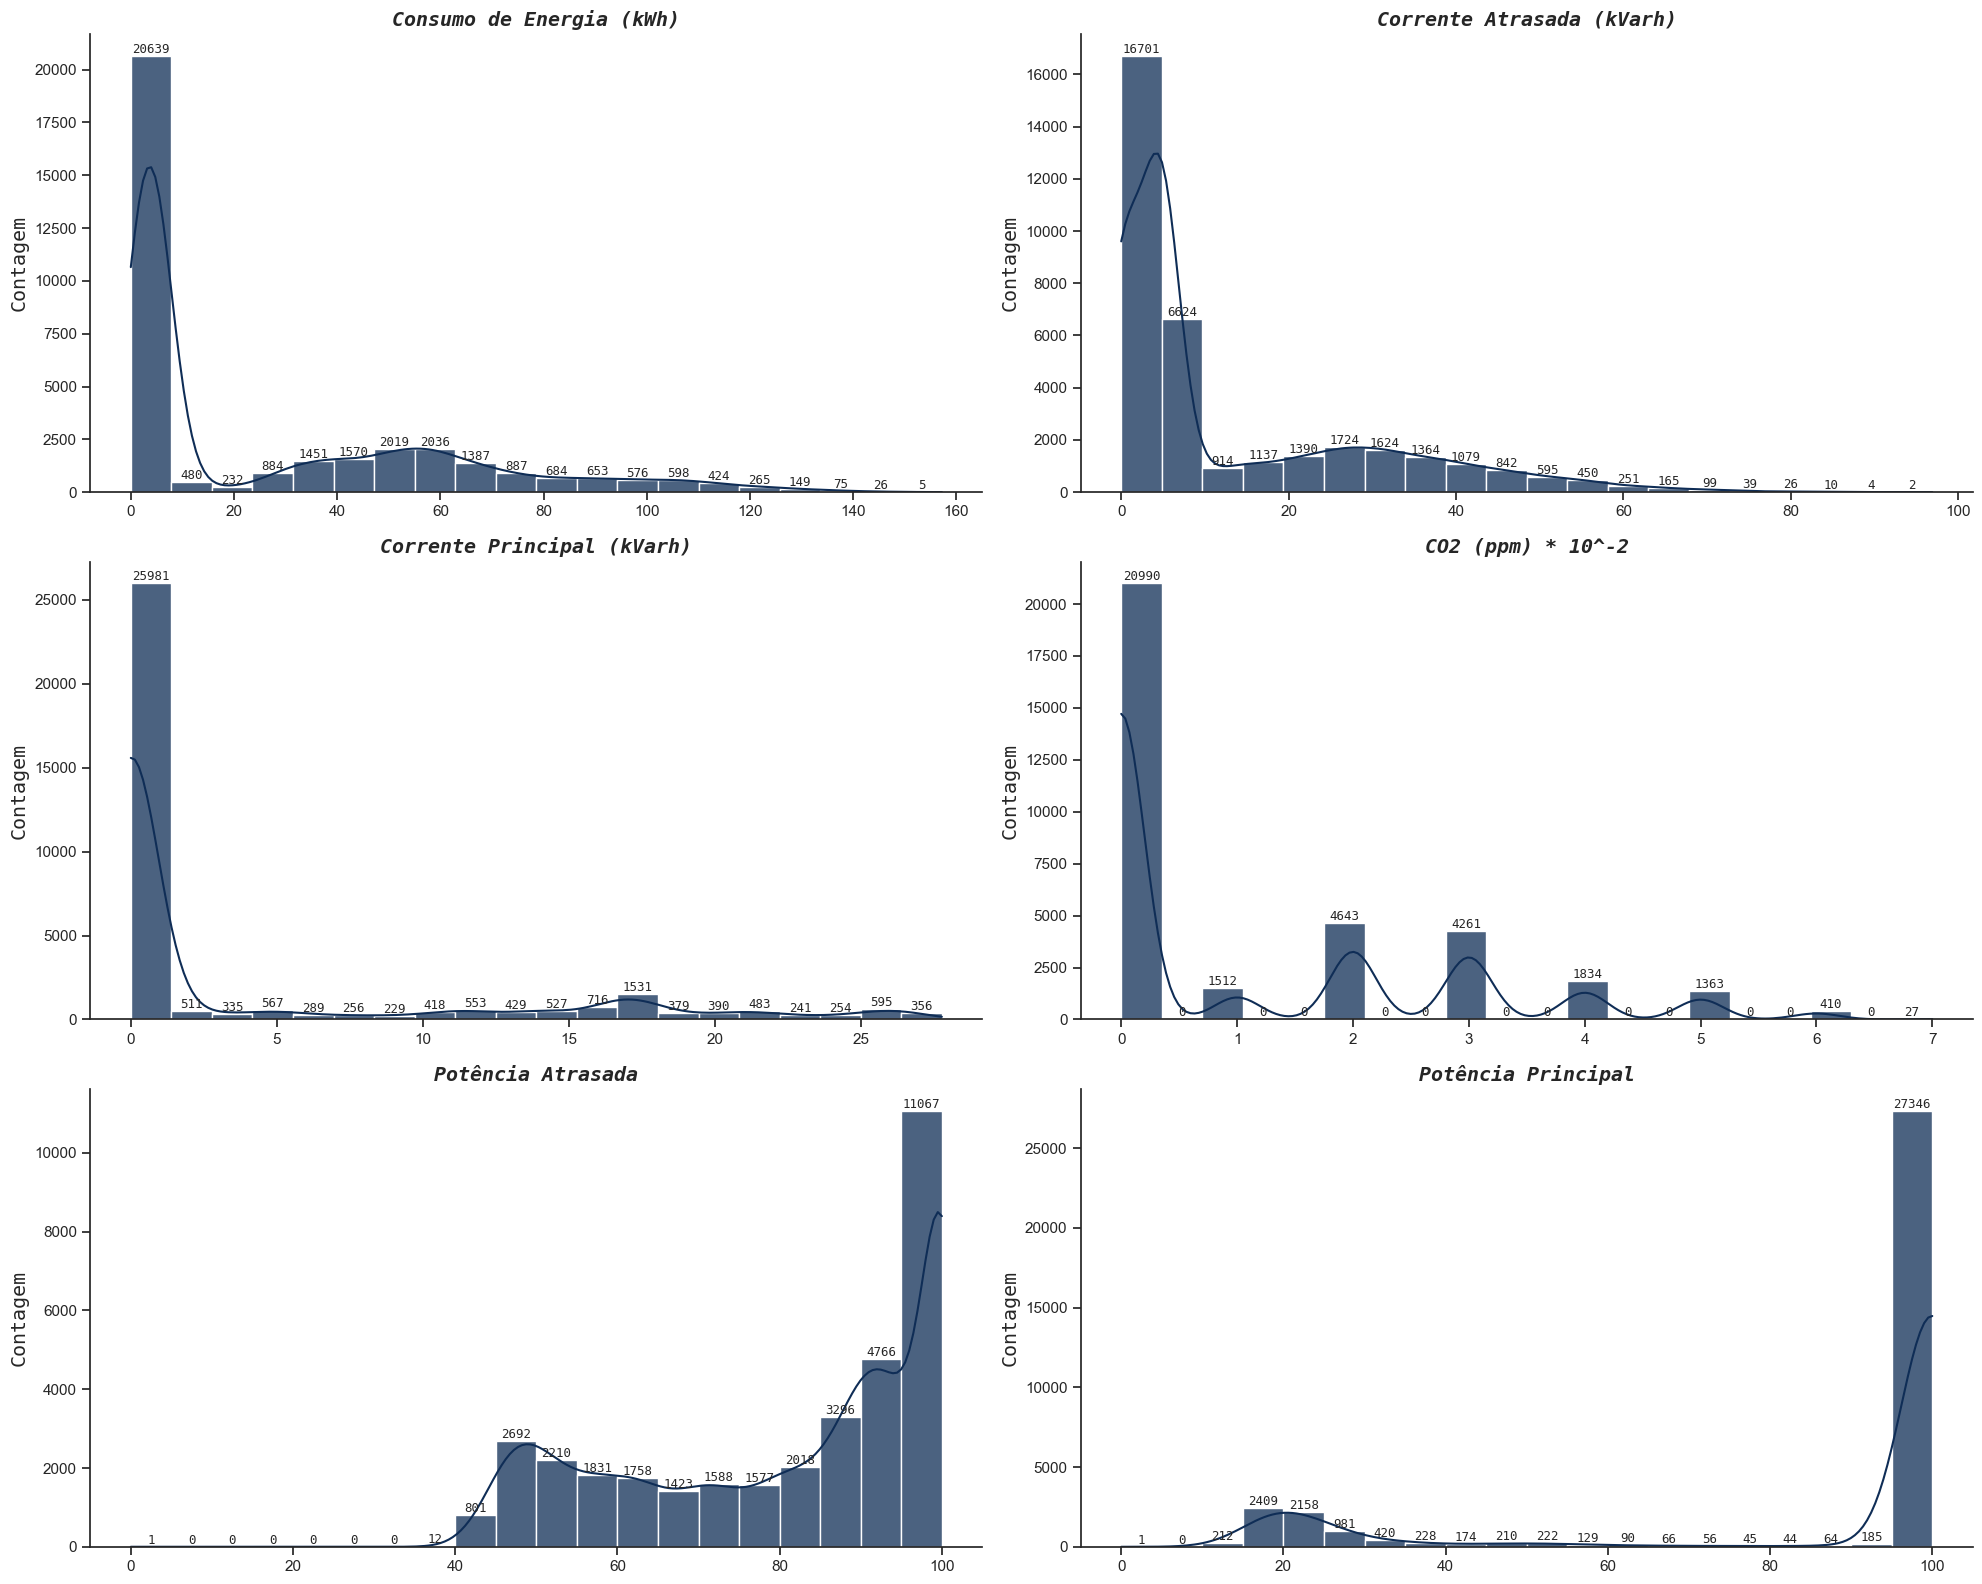

In [63]:
columns = df.drop(['data', 'estado_semana', 'dia_semana', 'tipo_carga', 'estacao', 'segundos_depois_meia_noite'], axis=1).columns
title=['Consumo de Energia (kWh)', 'Corrente Atrasada (kVarh)', 'Corrente Principal (kVarh)', 'CO2 (ppm) * 10^-2', 'Potência Atrasada', 'Potência Principal']
plot_histograms(df=df, columns=columns, n_rows=3, n_cols=2, title=title)
plt.show()

### Gráficos de Barra

Iremos agora analisar o comportamento das variáveis referentes a média de consumo energético

In [64]:
def create_bar(df_: pd, columns: list, n_rows: int, n_cols: int, rot=45):
    y_ = 'consumo_energia'
    fig = plt.figure(figsize=(20, 30))
    for i, column in enumerate(columns):
        for j in range (0, 2):
            ax = fig.add_subplot(n_rows, n_cols, 2*i + j + 1)
            if j:
                df = df_.groupby(by=column, as_index=False, sort=False)[y_].median()
            else:
                df = df_.groupby(by=column, as_index=False, sort=False)[y_].mean()
            try:
                df[column] = df[column].str.capitalize()
            except:
                pass
            
            sns.barplot(data=df, x=column, y=y_, palette=palette, ax=ax)
            for value in ax.containers:
                ax.bar_label(value)
            ax.tick_params(axis='x', labelrotation=rot, size=12)
            ax.tick_params(axis='y', size=12)
            ax.set_xlabel(column.capitalize(), fontsize='large', family='monospace')
            ax.set_ylabel("Consumo de Energia (kWh)", fontsize='large', family='monospace')
            if j:
                ax.set_title(f"Mediana de Consumo de Energia por {column.capitalize()}", fontsize='large', fontweight='bold', 
                             style='italic', family='monospace')
            else:
                ax.set_title(f"Média de Consumo de Energia por {column.capitalize()}", fontsize='large', fontweight='bold', 
                            style='italic', family='monospace')
    fig.tight_layout()

Para tal observação foi considerada as variáveis categóricas
- Co2 (Por possuir comportamento categórico)
- Estação do ano
- Dia da semana
- Estado da semana
- Tipo de carga

#### Algumas observações com os gráficos de barra

<h5>Em ordem de plotagem</h5>

<div style="line-height: 2;">
    <ol>
        <li>Co2</li>
        <ul>
            <li>O consumo de energia cresce conforme a emissão de Co2</li>
        </ul>
        <li>Estações do ano</li>
        <ul>
            <li>O agrupamento a partir das estações do ano deu-se por conta da hipótese de que em épocas mais quentes (verão) seria necessário mais energia que em épocas mais frias (inverno);</li>
            <li>Apesar dessa hipótese se mostrar verdadeira, a diferença representada pela média é baixa.</li>
        </ul>
        <li>Dia da semana e Estado da semana</li>
        <ul>
            <li>Uma grande fábrica produtora de aço necessita de funcionamento diário, porém a carga dos funcionários aos fins de semana seria diminuida.</li>
        </ul>
        <li>Tipo de carga</li>
        <ul>
            <li>Temos um ponto importante a salientar, apesar da baixa demanda energética para objetos com carga leve, a quantidade de elementos contabilizados como carga leve são exponencialmente maiores.</li>
            <li>Um dos fatores pode ser que o tempo para processar uma carga seja proporcional ao seu tamanho</li>
        </ul>
    </ol>
</div>

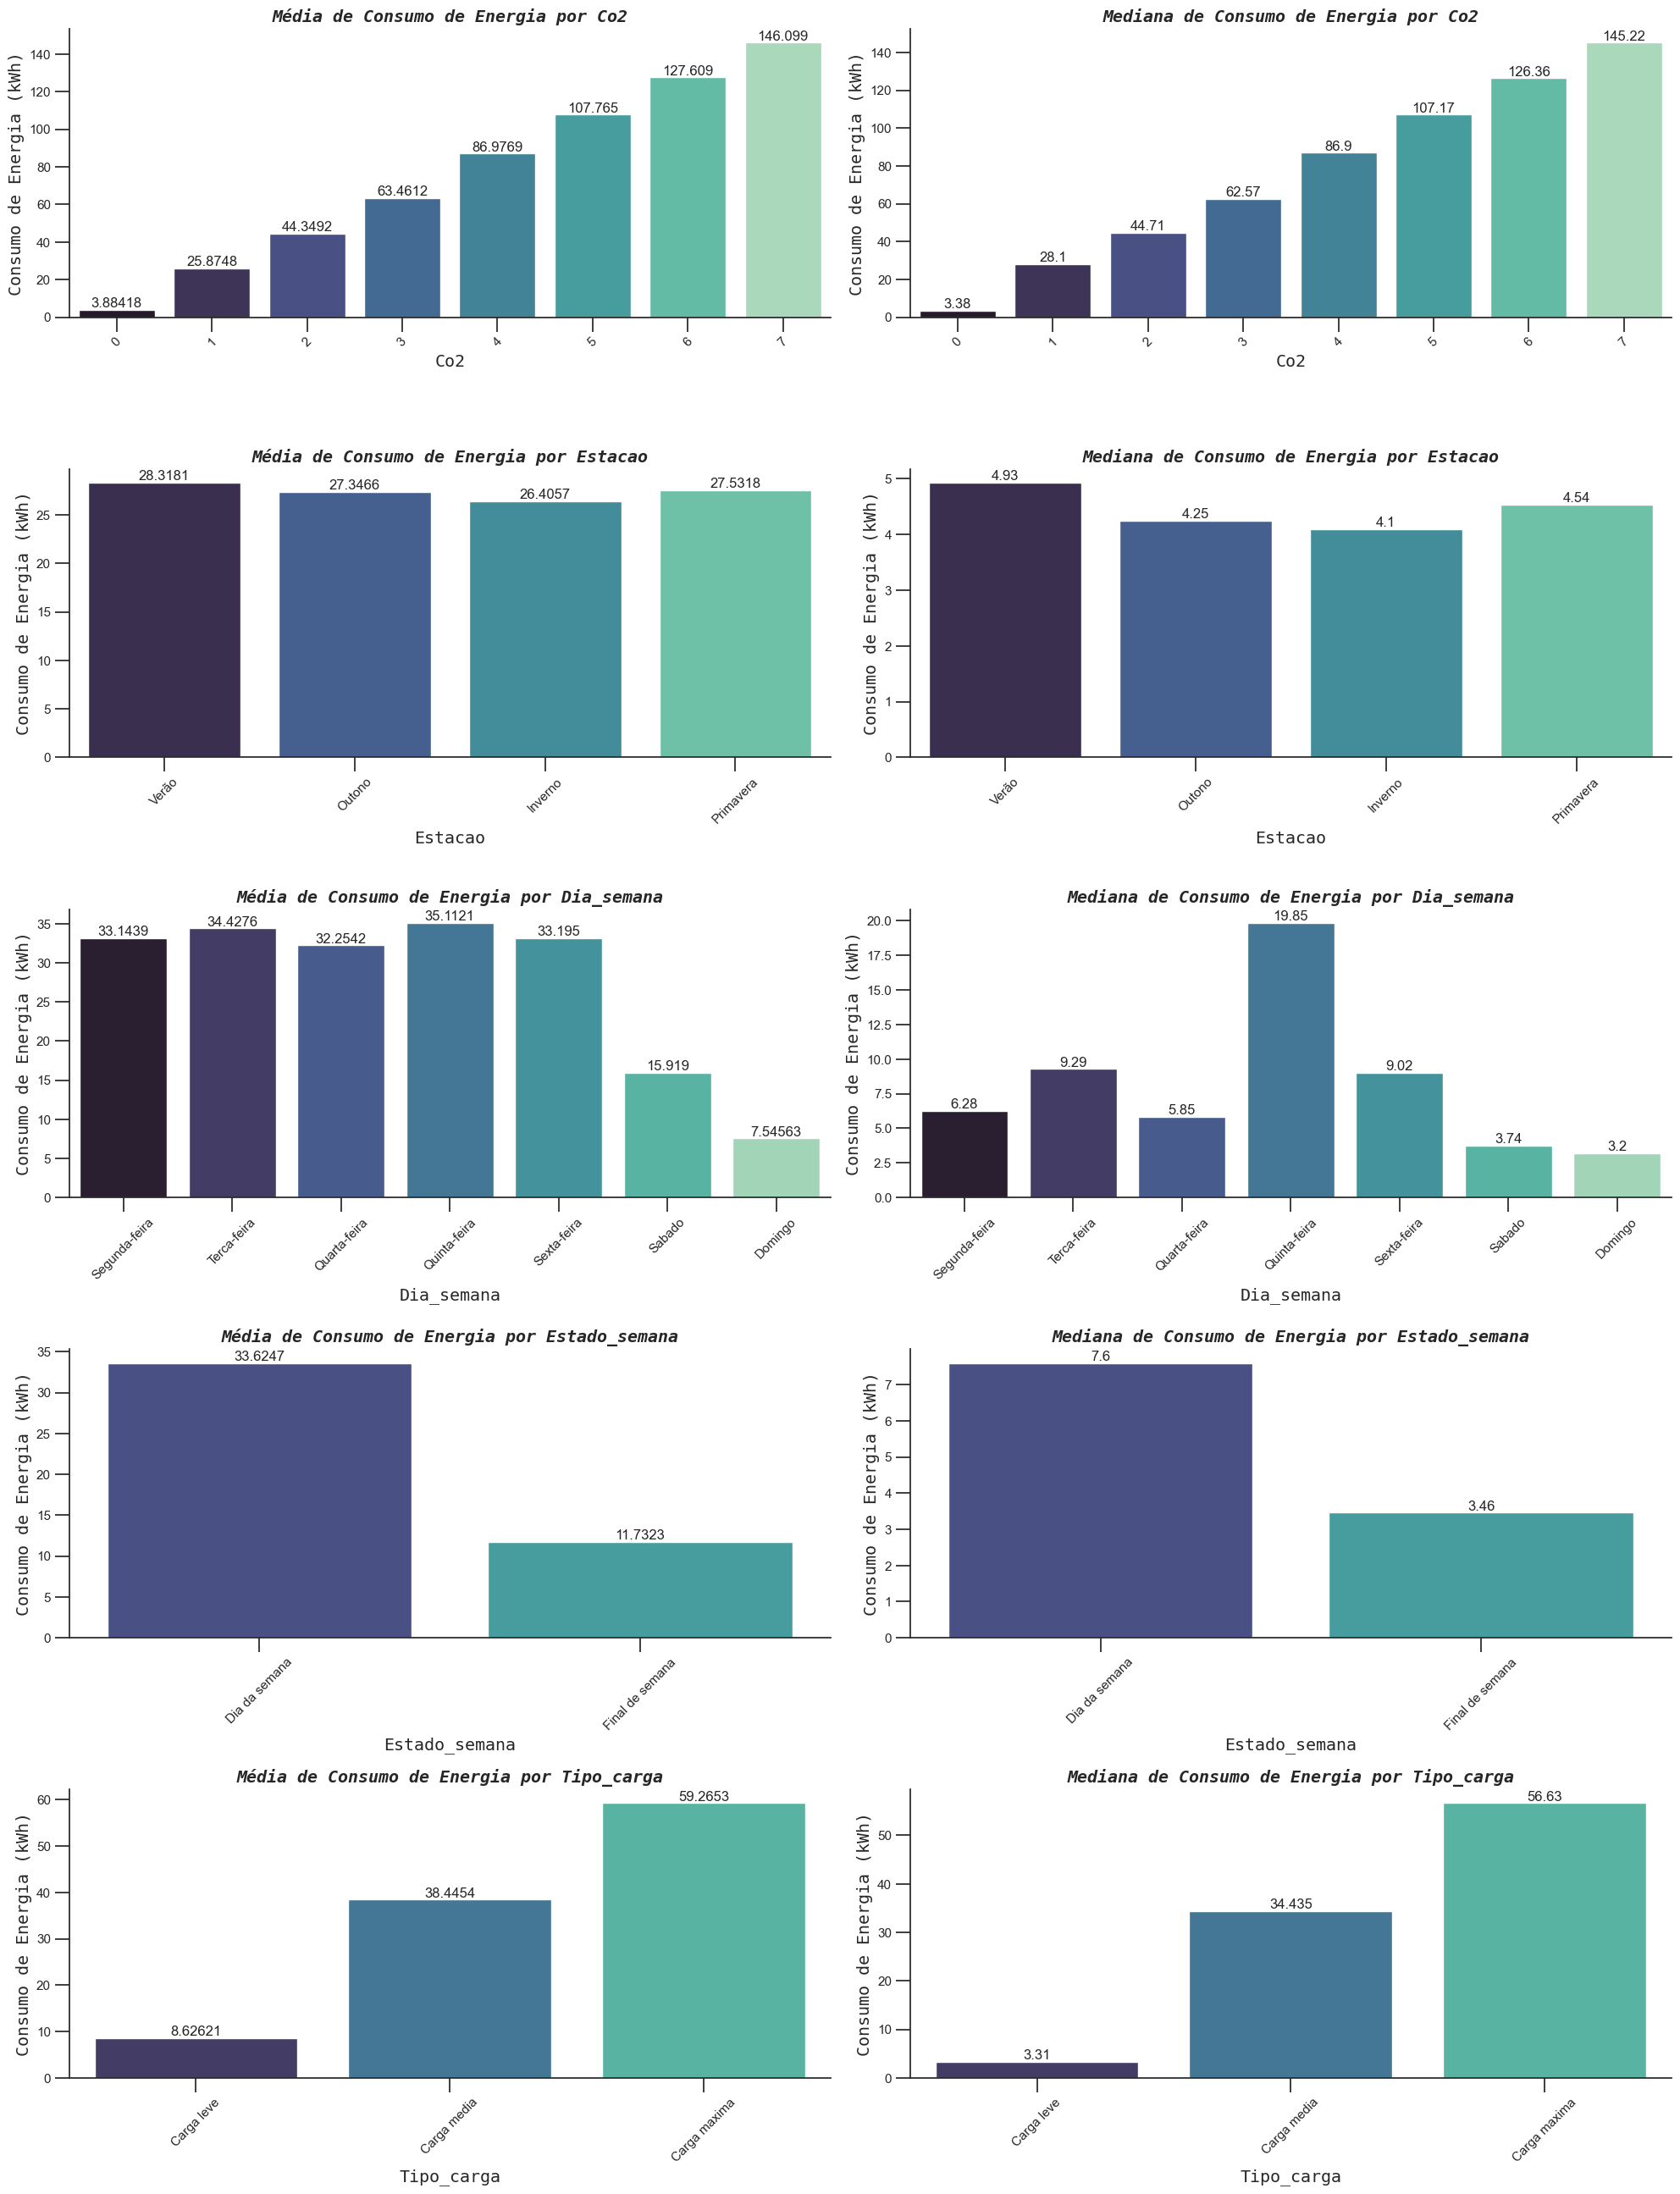

In [65]:
columns = ['co2', 'estacao', 'dia_semana', 'estado_semana', 'tipo_carga']
create_bar(df, columns, 6, 2)
plt.show()

### Gráficos de caixa

In [66]:
def create_box_plot(df_: pd, columns: list, title: list, n_rows: int, n_cols: int):
    y_ = 'consumo_energia'
    fig = plt.figure(figsize=(20, 16))
    for i, column in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df_, x=column, y=y_, ax=ax, palette=palette)
        ax.tick_params(axis='x', size=12)
        ax.tick_params(axis='y', size=12)
        ax.set_xlabel(column.capitalize(), fontsize='large', family='monospace')
        ax.set_ylabel("Consumo de Energia (kWh)", fontsize='large', family='monospace')
        ax.set_title(f"Boxplot de Consumo de Energia por {title[i]}", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
    fig.tight_layout()

Novamente iremos observar as variáveis categóricas

#### Algumas observações com os gráficos de caixa

Conforme aumentamos as observações temos maiores outliers, também podemos notar as diferenças entre os ranges de consumo energético.

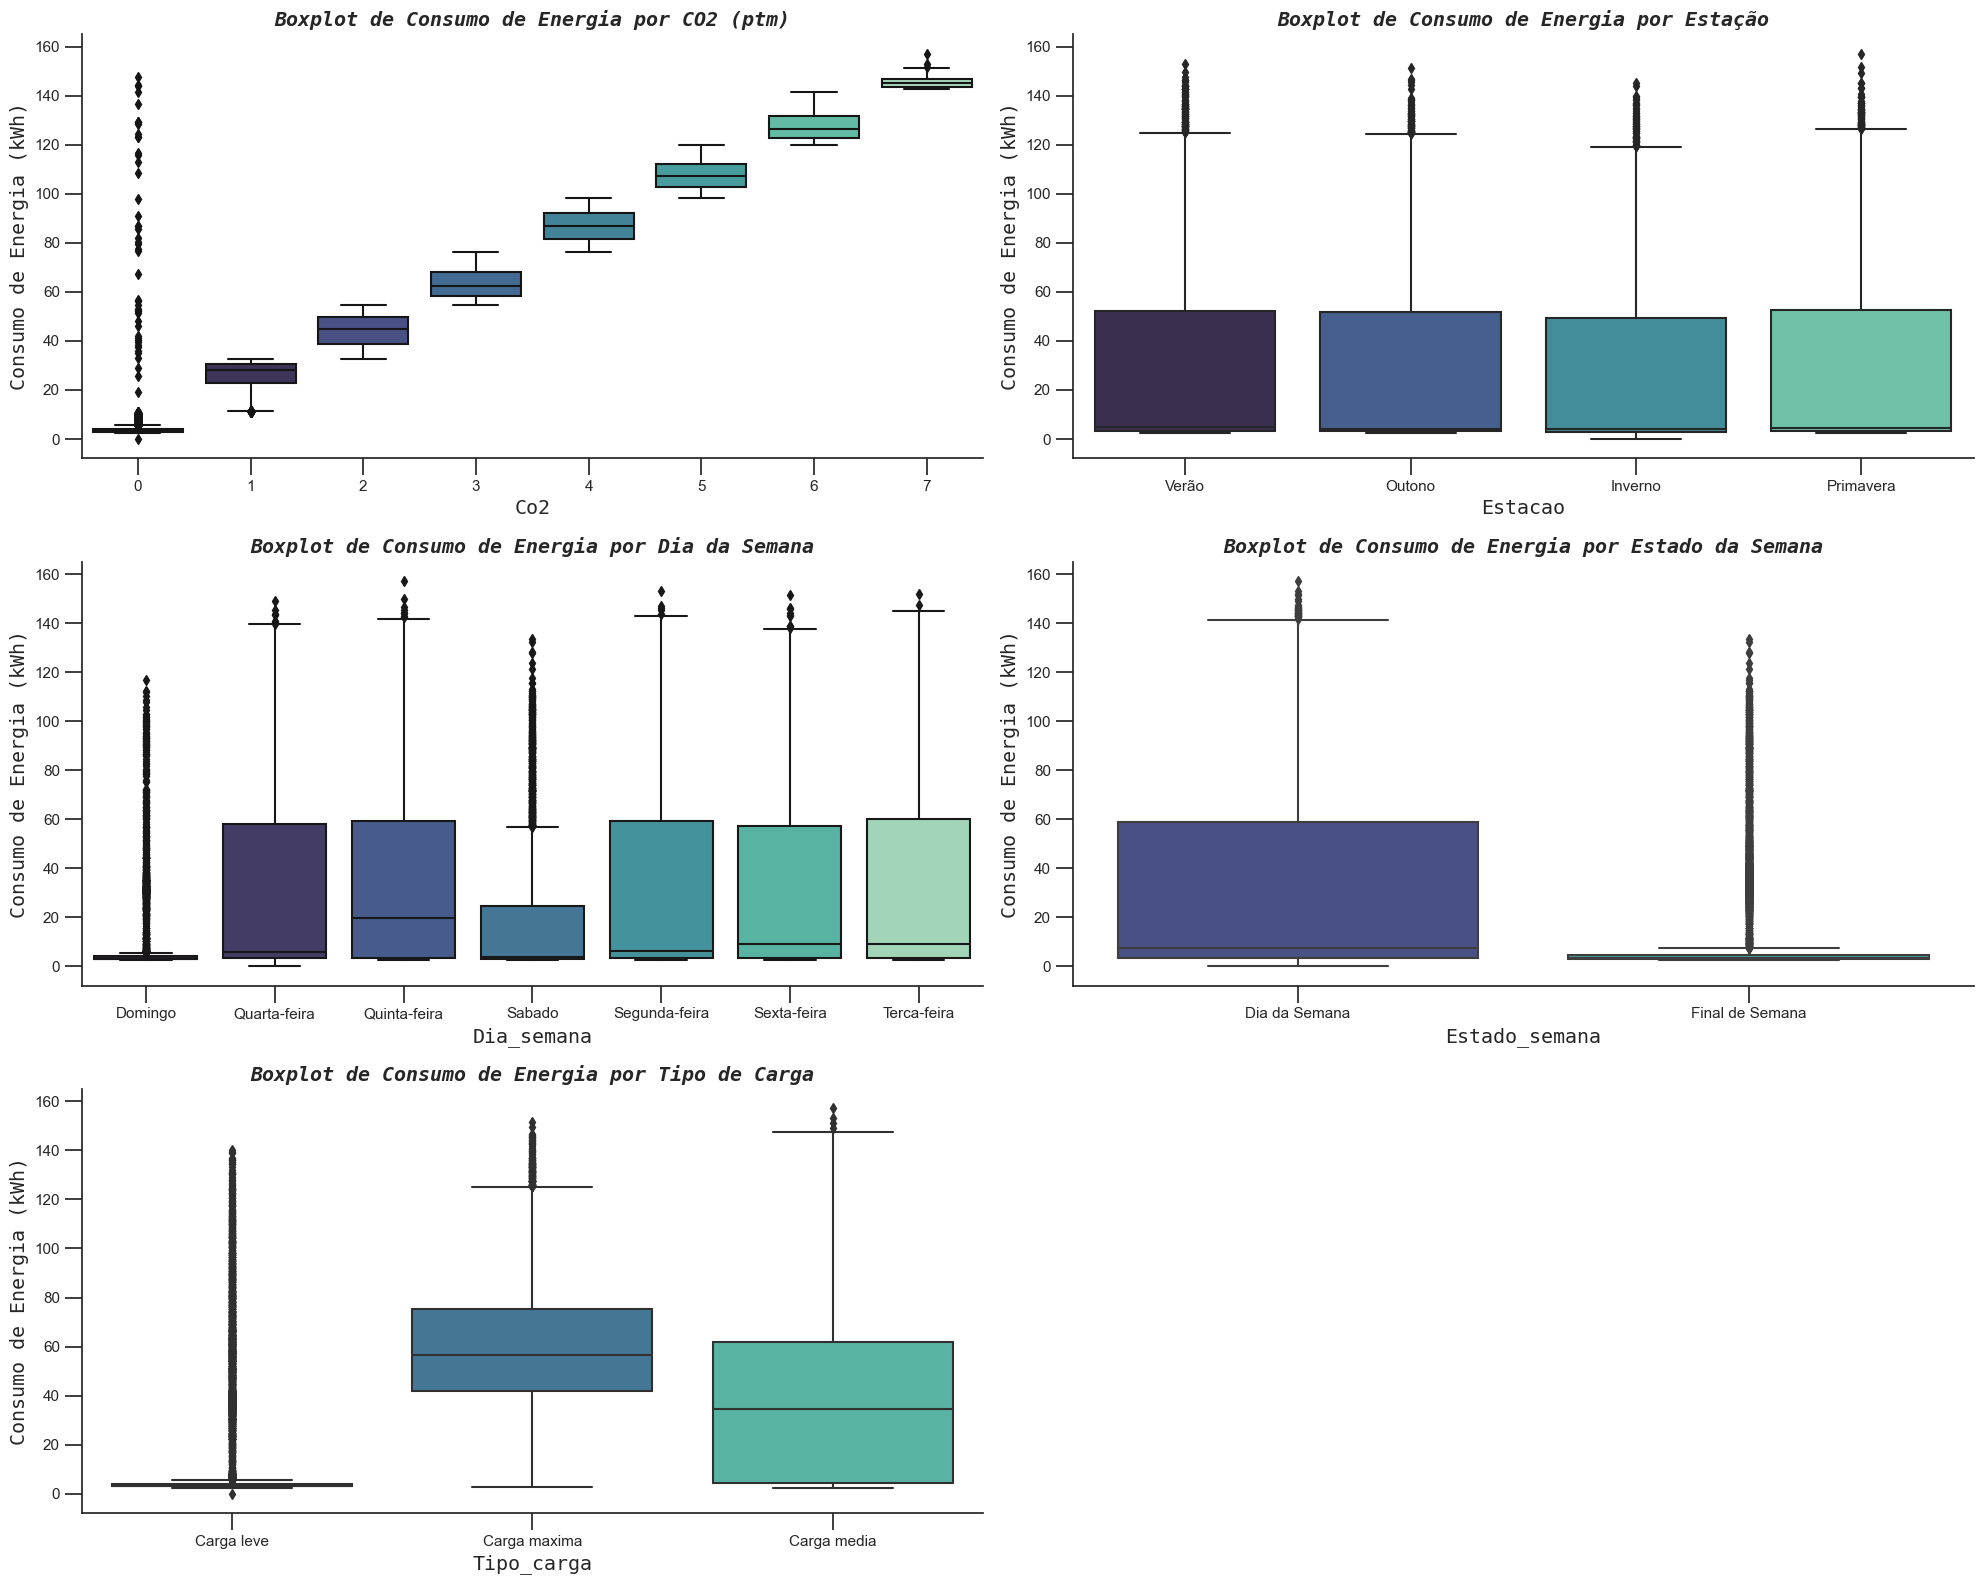

In [67]:
columns = ['co2', 'estacao', 'dia_semana', 'estado_semana', 'tipo_carga']
title = ['CO2 (ptm)', 'Estação', 'Dia da Semana', 'Estado da Semana', 'Tipo de Carga']
create_box_plot(df, columns, title, 3, 2)
plt.show()

Agora iremos ver na prática a quantidade de outliers a partir do intervalo interquantil.

Nos casos analisados existe apenas outlier em um dos lados (superior ou inferior).

In [68]:
def calculate_outliers(x: pd.Series) -> list:
    q1 = x.quantile(.25)
    q3 = x.quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return x[(x < lower_bound)].index.tolist(), x[(x > upper_bound)].index.tolist()

for column in df.drop(['data', 'estado_semana', 'dia_semana', 'segundos_depois_meia_noite', 'tipo_carga', 'estacao'], axis=1).columns:
    lower, upper = calculate_outliers(df[column])
    column = column.replace('_', ' ')
    column = column.capitalize()
    print(f"{column}: Lower = {len(lower)}, Upper = {len(upper)}, Total = {len(lower) + len(upper)}")
    
del calculate_outliers

Consumo energia: Lower = 0, Upper = 328, Total = 328
Corrente atrasada: Lower = 0, Upper = 1059, Total = 1059
Corrente principal: Lower = 0, Upper = 7759, Total = 7759
Co2: Lower = 0, Upper = 437, Total = 437
Potencia atrasado: Lower = 1, Upper = 0, Total = 1
Potencia principal: Lower = 8327, Upper = 0, Total = 8327


Analisaremos também a amplitude desses dados:

In [69]:
def calculate_amplitude(x: pd.Series) -> float:
    return x.max() - x.min()

for column in df.drop(['data', 'estado_semana', 'dia_semana', 'segundos_depois_meia_noite', 'tipo_carga', 'estacao'], axis=1).columns:
    amplitude = calculate_amplitude(df[column])
    column = column.replace('_', ' ')
    column = column.capitalize()
    print(f"{column}: Amplitude = {amplitude:.2f}")
    
del calculate_amplitude

Consumo energia: Amplitude = 157.18
Corrente atrasada: Amplitude = 96.91
Corrente principal: Amplitude = 27.76
Co2: Amplitude = 7.00
Potencia atrasado: Amplitude = 100.00
Potencia principal: Amplitude = 100.00


### Gráfico de dispersão

<h5>Algumas observações</h5>

<div style="line-height: 2;">
    <ol>
        <li>Confirmação da alta correlação (linear) positiva entre o consumo de energia e a corrente atrasada</li>
        <li>Observada uma correlação (linear) negativa entre corrente principal e potencia principal</li>
        <li>Correlação (não linear) positiva entre potencia principal e corrente atrasada</li>
    </ol>
</div>

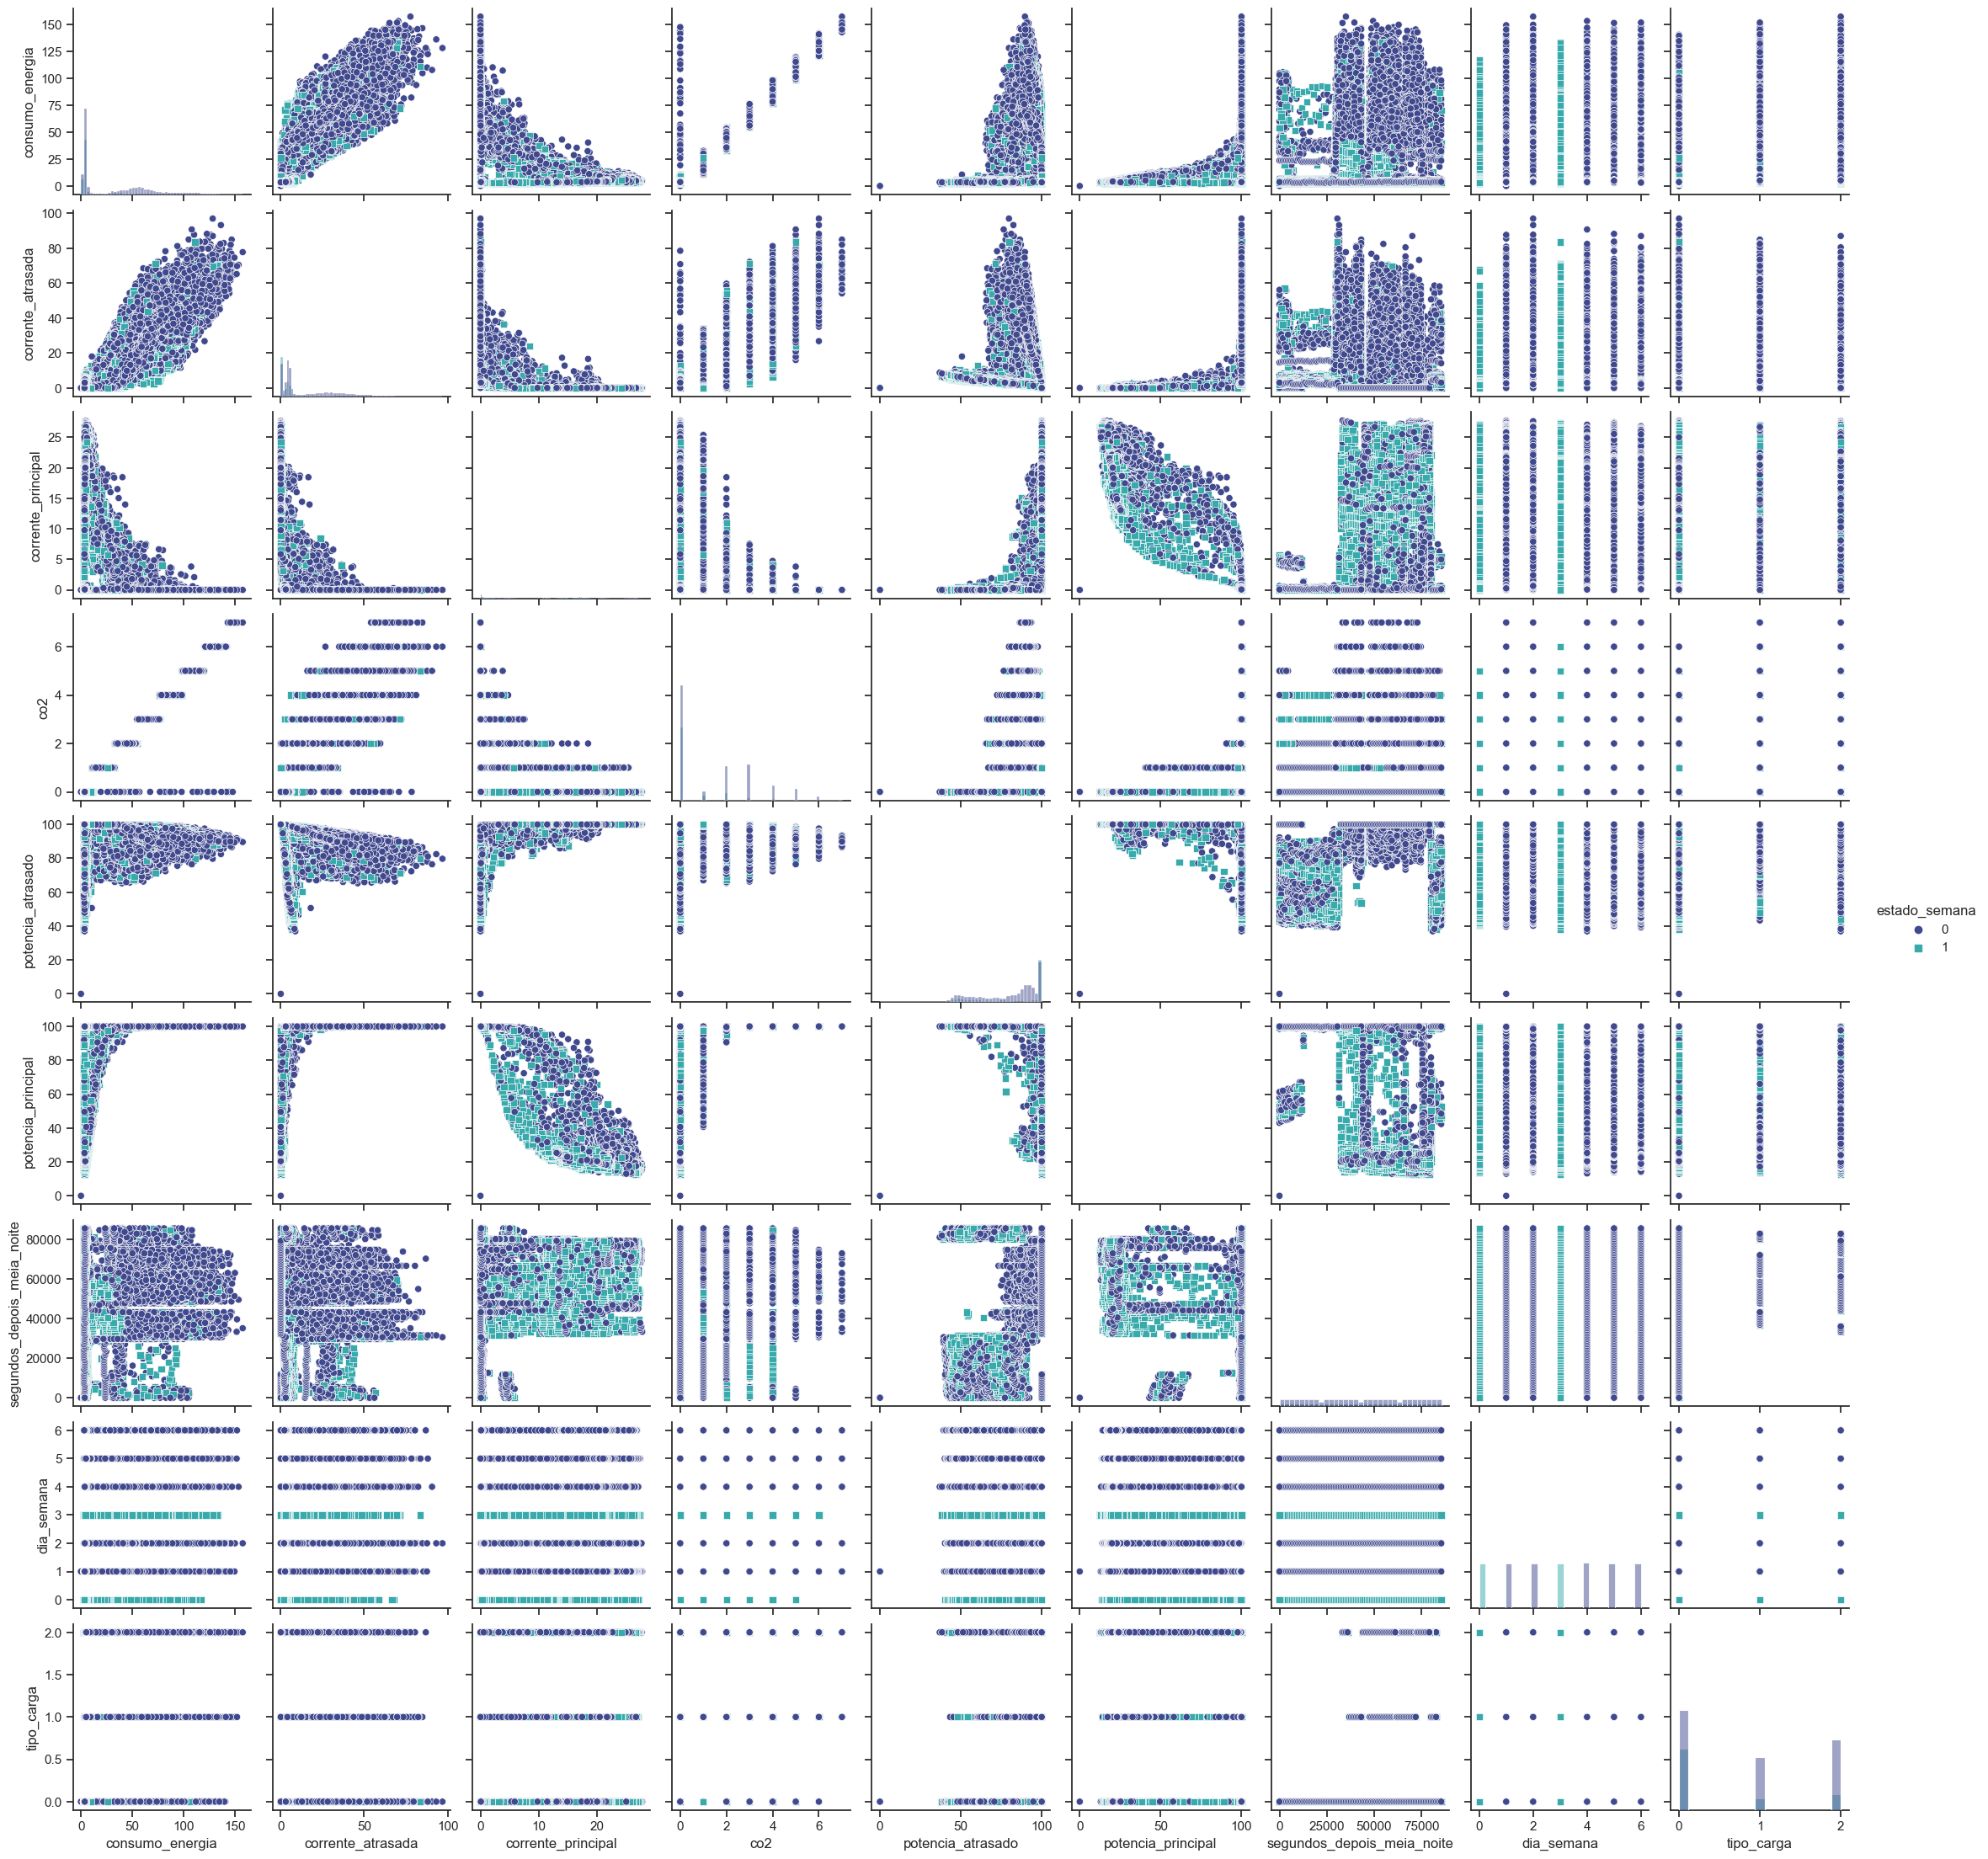

In [70]:
sns.pairplot(df, hue="estado_semana", palette=palette, markers=["o", "s"], diag_kind="hist")
plt.show()

### Matriz de correlação

Agora para confirmar as observações das correlações lineares foi plotado a matriz de correlação utilizando os três métodos:
- Pearson (linear)
- Kendall (não linear)
- Spearman (não linear)

In [80]:
for item in df.select_dtypes(include='category').columns:
    df[item] = df[item].cat.codes

def plot_correlation_matrix(df: pd, columns: list, n_rows: int, n_cols: int) -> list:
    fig = plt.figure(figsize=(20, 16))
    result = []
    for i, method in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        corr = df.corr(numeric_only=True, method=method)
        result.append(corr)
        sns.heatmap(corr, cmap="crest", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', ax=ax)
        ax.set_title(f'Método: {method.capitalize()}', fontsize='large', fontweight='bold', style='italic', family='monospace')
    fig.tight_layout()
    return result
plt.show()

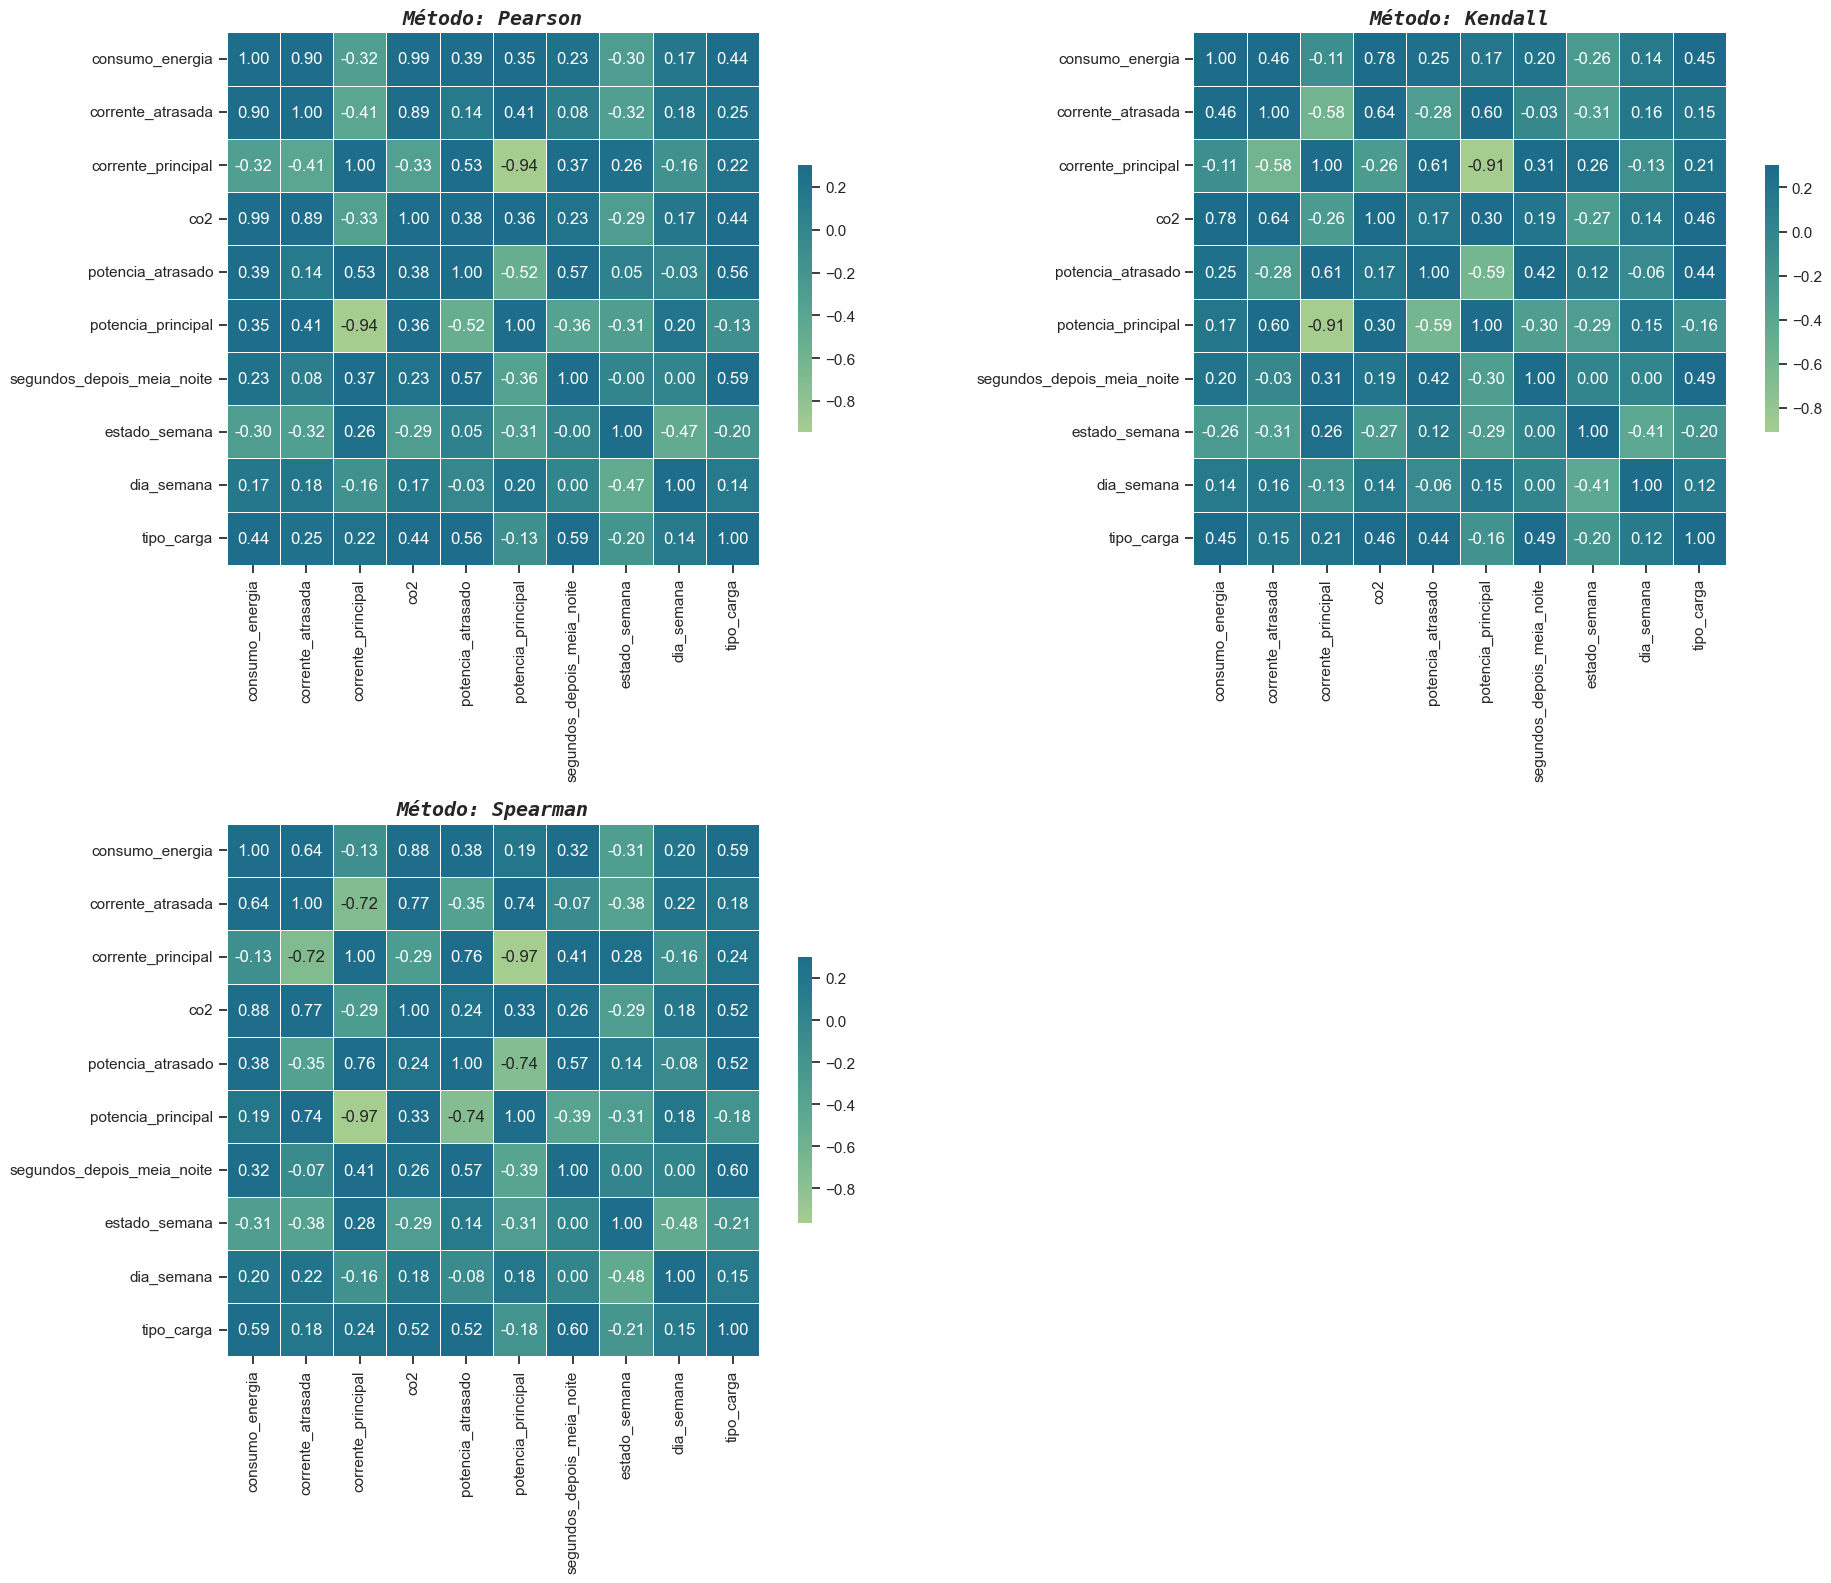

In [83]:
for item in df.select_dtypes(include='category').columns:
    df[item] = df[item].cat.codes

matrix_of_corr = plot_correlation_matrix(df, ['pearson', 'kendall', 'spearman'], 2, 2)

plt.show()

In [92]:
corr_to_analysis = []
for i, corr in enumerate(matrix_of_corr):
    match i:
        case 0:
            method = 'Pearson'
        case 1:
            method = 'Kendall'
        case 2:
            method = 'Spearman'
    for item in corr.columns:
        strong_corr = zip(corr[item].abs().sort_values(ascending=False)[1:4].index, corr[item].abs().sort_values(ascending=False)[1:4].values)
        for index, value in strong_corr:
            if (value >= 0.75) and ((method, item, index, value) not in corr_to_analysis) and ((method, index, item, value) not in corr_to_analysis):
                corr_to_analysis.append((method, item, index, value))

In [ ]:
corr_to_analysis = pd.DataFrame(corr_to_analysis, columns=['Método', 'Variável 1', 'Variável 2', 'Correlação'])

In [94]:
corr_to_analysis.sort_values(by='Correlação', ascending=False)

Método          Variável 1          Variável 2  Correlação
0   Pearson     consumo_energia                 co2    0.988180
8  Spearman  corrente_principal  potencia_principal    0.967206
3   Pearson  corrente_principal  potencia_principal    0.944039
5   Kendall  corrente_principal  potencia_principal    0.910076
1   Pearson     consumo_energia   corrente_atrasada    0.896150
2   Pearson   corrente_atrasada                 co2    0.886948
6  Spearman     consumo_energia                 co2    0.881514
4   Kendall     consumo_energia                 co2    0.776822
7  Spearman   corrente_atrasada                 co2    0.774188
9  Spearman  corrente_principal   potencia_atrasado    0.755688

In [96]:
corr.consumo_energia.abs().sort_values(ascending=False)[1:5]

co2                  0.881514
corrente_atrasada    0.644937
tipo_carga           0.591642
potencia_atrasado    0.375158
Name: consumo_energia, dtype: float64

In [95]:
corr.consumo_energia.abs().sort_values(ascending=True)[:4]

corrente_principal    0.131703
potencia_principal    0.193501
dia_semana            0.200803
estado_semana         0.313772
Name: consumo_energia, dtype: float64

## Análise temporal

Apenas por curiosidade foi feita uma análise básica temporal

In [72]:
df_groupby_day = df.set_index('data').resample('D').agg(
    {
        'consumo_energia': 'sum',
        'corrente_atrasada': 'sum',
        'corrente_principal': 'sum',
        'co2': 'mean',
        'potencia_atrasado': 'mean',
        'potencia_principal': 'mean',
        'dia_semana': lambda x: x.mode()[0],
        'tipo_carga': lambda x: x.mode()[0],
        'estacao': lambda x: x.mode()[0],
    }
).copy()

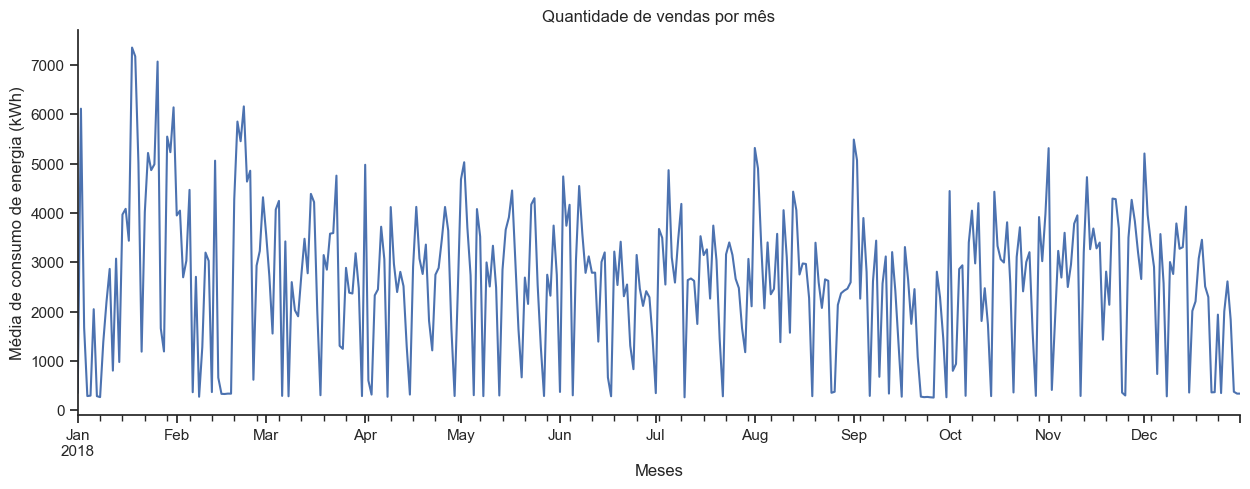

In [73]:
plt.figure(figsize=(15, 5))

df_groupby_day['consumo_energia'].plot()
plt.xlabel('Meses')
plt.ylabel('Média de consumo de energia (kWh)')
plt.title('Quantidade de vendas por mês')
plt.show()

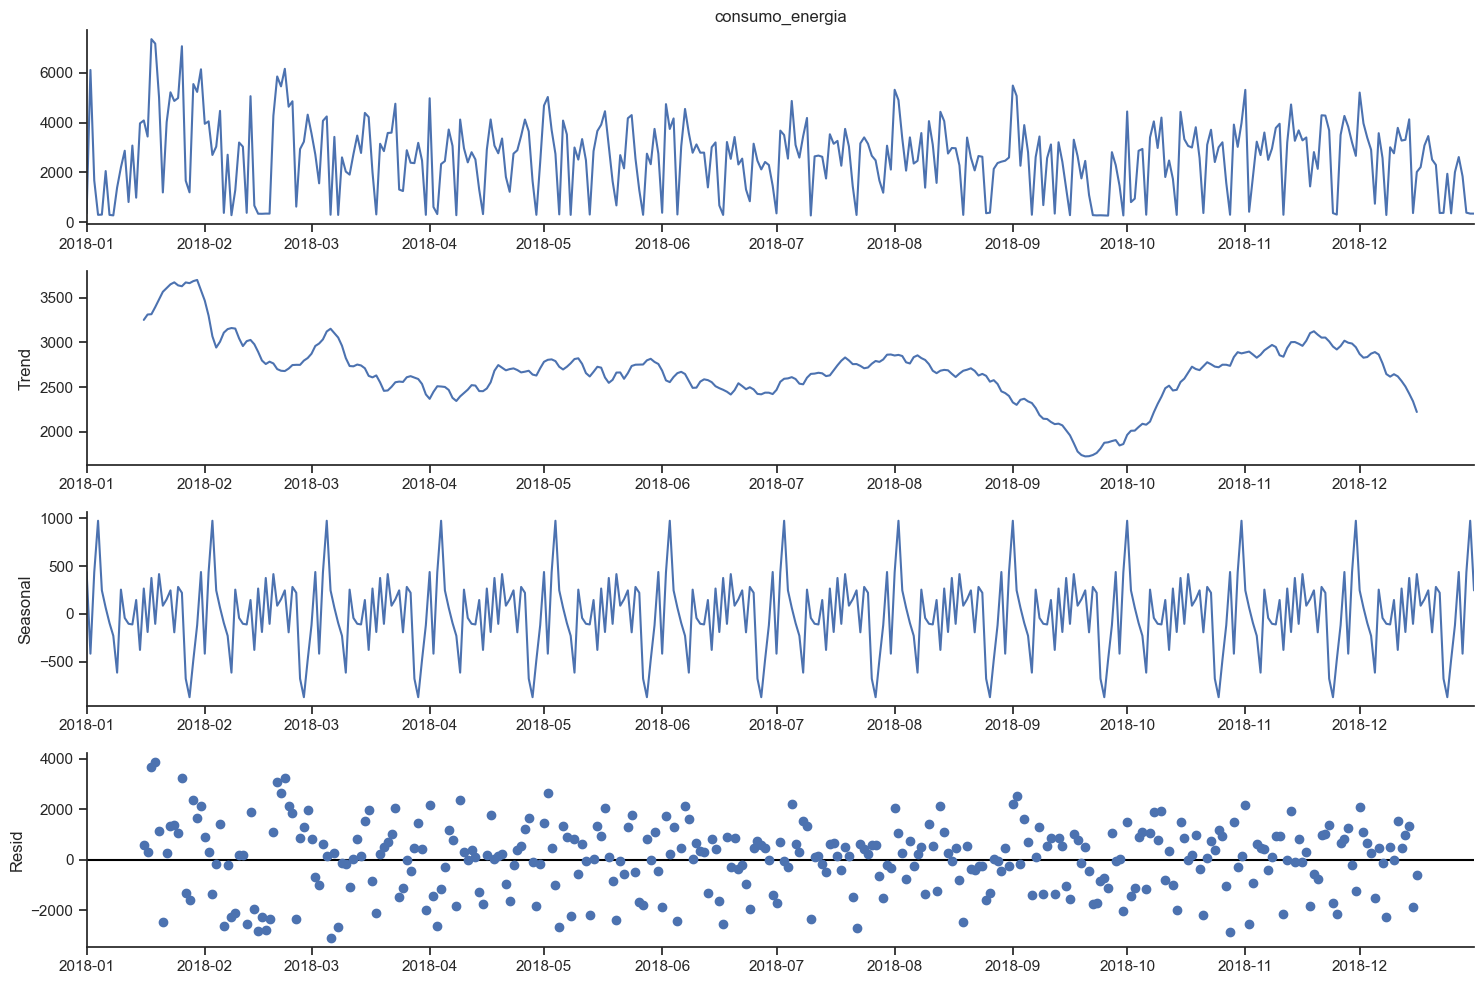

In [74]:
decomposed = seasonal_decompose(df_groupby_day['consumo_energia'], model='additive', period=30)

fig = decomposed.plot()
fig.set_size_inches((15, 10))
fig.tight_layout()
plt.show()


# Conclusão

Foram realizadas diversas análises para compreender melhor a distribuição dos dados, identificar possíveis anomalias e outliers. Além disso, foram exploradas as relações entre as variáveis e como elas se correlacionam com a variável alvo.

Durante o processo de análise, foi possível identificar algumas questões importantes que precisam ser levadas em consideração durante a criação do modelo. Se duas variáveis estão altamente correlacionadas, isso pode indicar que elas estão medindo essencialmente a mesma coisa.

Correlações fortes (>=0.9)

| Variável 1 | Variável 2 | Tipo de Correlação | 
|---|---|---|
| Consumo de Energia | Corrente atrasada | Linear Positiva |
| Consumo de Energia | Co2 | Linear Positiva |
| Co2 | Corrente atrasada | Linear Positiva |
| Potência principal | Corrente atrasada | Não Linear Positiva |
| Corrente principal | Potência principal | Não Linear Negativa |

Portanto as variáveis que não possuem uma alta correlação com a variável target podem ser eliminadas para criação do modelo, deve-se entretanto observar a performance por conta do problema de multicolinearidade.

- Potência principal

Outro ponto importante é o outlier presente no index = 29855, deve-se entender o motivo de sua aparição, afinal caso o medidor esteja enviesado será necessário avaliar melhor os dados.

É importante levar em consideração todos os insights e padrões identificados, bem como as questões que precisam ser tratadas, a fim de desenvolver um modelo preciso e eficiente.